In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from tqdm import tqdm
import pandas as pd
import numpy as np

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
dataset_train,dataset_test = load_datasets("Dialysis",test_size=0.2)

In [3]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1
hidden_dim = [15,15]
batch_size = 128
print_every = 5
lr = 1e-3
num_epochs = 15

In [4]:
dataloader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([5444, 74])

In [5]:
clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)

optimizer = Adam(clf.parameters(),lr=lr)
criterion = right_censored

In [6]:
epochs,train_loss = train(model=clf,dataloader_train=dataloader_train,optimizer=optimizer,criterion=criterion,print_every=print_every,epochs=num_epochs)

Epoch 5, LL=6704.340
Epoch 10, LL=5982.213
Epoch 15, LL=5928.324
Finished Training


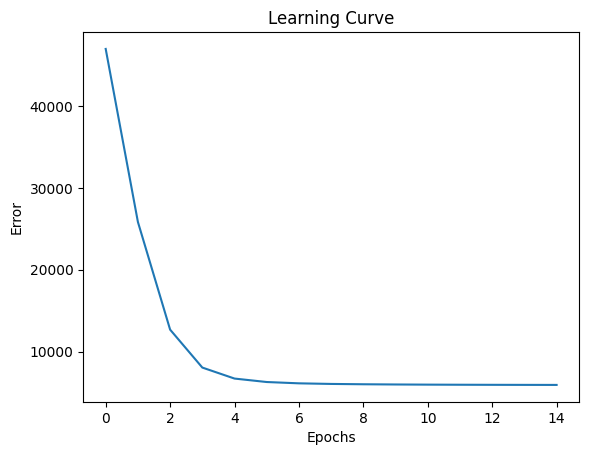

In [7]:
plt.plot(epochs,train_loss)
plt.ylabel("Error"); plt.xlabel("Epochs")
plt.title("Learning Curve")
plt.show()

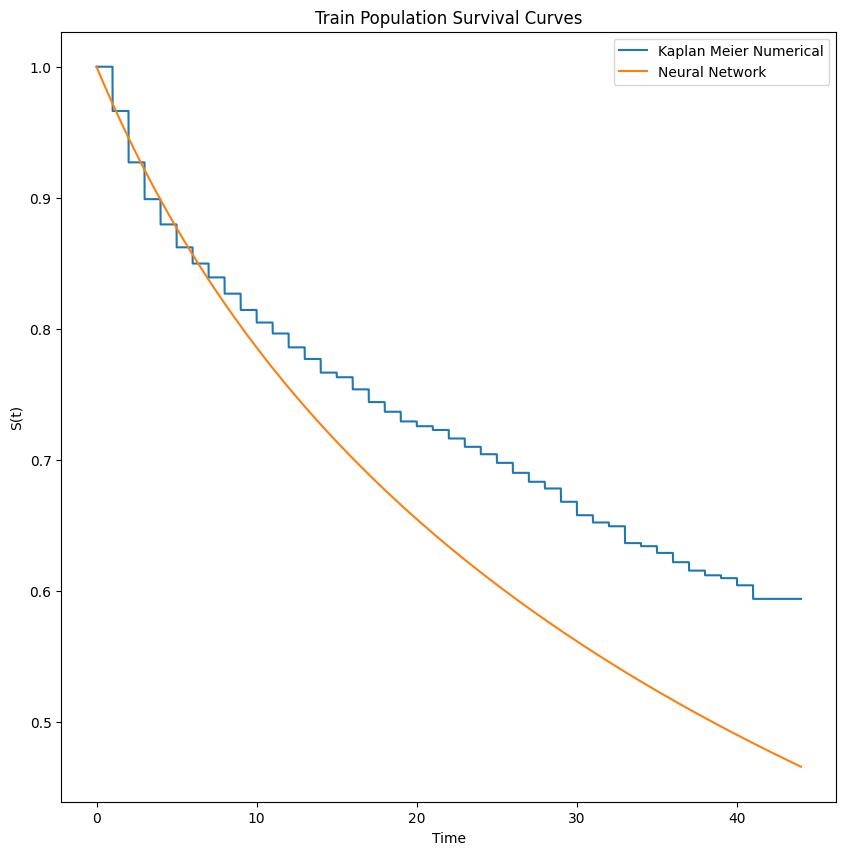

In [8]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_given_x = clf.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Train Population Survival Curves")
plt.show()

## AUTO LIRPA 

In [9]:
# model = BoundedModule(loss_clf, (X_train,T_train,E_train))
# # Define perturbation. Here we add Linf perturbation to input data.
# ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# # Make the input a BoundedTensor with the pre-defined perturbation.
# my_input = BoundedTensor(torch.Tensor(X_train), ptb)
# # Regular forward propagation using BoundedTensor works as usual.
# prediction = model(my_input,T_train,E_train)
# # Compute LiRPA bounds using CROWN
# lb, ub = model.compute_bounds(x=(my_input,T_train,E_train), method="backward")

In [10]:
# model = BoundedModule(loss_clf, (X_train,T_train,E_train))
# # Define perturbation. Here we add Linf perturbation to input data.
# ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# # Make the input a BoundedTensor with the pre-defined perturbation.
# my_input = BoundedTensor(torch.Tensor(X_train), ptb)
# # Regular forward propagation using BoundedTensor works as usual.
# # prediction = model(my_input,T_train,E_train)
# # Compute LiRPA bounds using CROWN
# lb, ub = model.compute_bounds(x=(my_input,T_train,E_train), method="backward",bound_upper=False)

In [11]:
"""
A simple script to train certified defense using the auto_LiRPA library.

We compute output bounds under input perturbations using auto_LiRPA, and use
them to form a "robust loss" for certified defense.  Several different bound
options are supported, such as IBP, CROWN, and CROWN-IBP. This is a basic
example on MNIST and CIFAR-10 datasets with Lp (p>=0) norm perturbation. For
faster training, please see our examples with loss fusion such as
cifar_training.py and tinyimagenet_training.py
"""

import time
import random
import multiprocessing
import argparse
import torch.optim as optim
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import *
from auto_LiRPA.utils import MultiAverageMeter
from auto_LiRPA.eps_scheduler import LinearScheduler, AdaptiveScheduler, SmoothedScheduler, FixedScheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms



def Train(model_loss, t, loader, eps_scheduler, norm, train, opt, bound_type, method='robust'):
    meter = MultiAverageMeter()
    if train:
        model_loss.train()
        eps_scheduler.train()
        eps_scheduler.step_epoch()
        eps_scheduler.set_epoch_length(int((len(loader.dataset) + loader.batch_size - 1) / loader.batch_size))
    else:
        model_loss.eval()
        eps_scheduler.eval()

    for i, data in enumerate(loader):
        start = time.time()
        eps_scheduler.step_batch()
        eps = eps_scheduler.get_eps()
        xi,ti,yi = data

        # For small eps just use natural training, no need to compute LiRPA bounds
        batch_method = method
        if eps < 1e-20:
            batch_method = "natural"
        if train:
            opt.zero_grad()

        # ptb = PerturbationLpNorm(norm=norm, eps=torch.Tensor([epsilon]))


        # Specify Lp norm perturbation.
        # When using Linf perturbation, we manually set element-wise bound x_L and x_U. eps is not used for Linf norm.
        if norm > 0:
            ptb = PerturbationLpNorm(norm=norm, eps=eps)
        elif norm == 0:
            ptb = PerturbationL0Norm(eps = eps_scheduler.get_max_eps(), ratio = eps_scheduler.get_eps()/eps_scheduler.get_max_eps())
        
        # Make the input a BoundedTensor with the pre-defined perturbation.
        x_bounded = BoundedTensor(xi, ptb)

        regular_loss = model_loss(xi,ti,yi).sum() # regular Right Censoring
        meter.update('Loss', regular_loss.item(), xi.size(0))
        if batch_method == "robust":
            # Compute LiRPA bounds using CROWN
            lb, ub = model_loss.compute_bounds(x=(x_bounded,ti,yi),IBP=False, method="backward",bound_upper=True,bound_lower=False)
            robust_loss = ub.sum()
            loss = robust_loss
        elif batch_method == "natural":
            loss =  regular_loss
        if train:
            (.1*loss+0.9*regular_loss).backward()
            eps_scheduler.update_loss(loss.item() - regular_loss.item())
            opt.step()
        meter.update('Loss', loss.item(), xi.size(0))
        if batch_method != "natural":
            meter.update('Robust_Loss', robust_loss.item(), xi.size(0))

        meter.update('Time', time.time() - start)
        if i % 10 == 0 and train:
            print('[{:2d}:{:4d}]: eps={:.8f} {}'.format(t, i, eps, meter))
    print('[{:2d}:{:4d}]: eps={:.8f} {}'.format(t, i, eps, meter))



C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [12]:
class ARGS(object):
    def __init__(self):
        pass

In [13]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=num_epochs
args.lr = 1e-3
args.scheduler_name = "SmoothedScheduler"
# args.scheduler_opts = "start=5,length=10"
args.scheduler_opts = "start=5,length=10"

args.save_model = "apple.pth"


In [14]:
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)
clf_fragile.load_state_dict(clf.state_dict())

<All keys matched successfully>

In [15]:
# model = BoundedModule(clf, X_train)
loss_clf = RightCensorWrapper(clf)
X_train,T_train,E_train = dataloader_train.dataset.tensors
model_loss = BoundedModule(loss_clf, (X_train,T_train,E_train))


In [16]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)


## Step 4 prepare optimizer, epsilon scheduler and learning rate scheduler
opt = optim.Adam(model_loss.parameters(), lr=args.lr)
norm = float(args.norm)
lr_scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
eps_scheduler = eval(args.scheduler_name)(args.eps, args.scheduler_opts)
print("Model structure: \n", str(clf))

## Step 5: start training
if args.verify:
    eps_scheduler = FixedScheduler(args.eps)
    with torch.no_grad():
        Train(model, 1, test_data, eps_scheduler, norm, False, None, args.bound_type)
else:
    timer = 0.0
    for t in range(1, args.num_epochs+1):
        if eps_scheduler.reached_max_eps():
            # Only decay learning rate after reaching the maximum eps
            lr_scheduler.step()
        print("Epoch {}, learning rate {}".format(t, lr_scheduler.get_lr()))
        start_time = time.time()
        Train(model_loss, t, dataloader_train, eps_scheduler, norm, True, opt, args.bound_type)
        epoch_time = time.time() - start_time
        timer += epoch_time
        print('Epoch time: {:.4f}, Total time: {:.4f}'.format(epoch_time, timer))
        print("Evaluating...")
        with torch.no_grad():
            Train(model_loss, t, dataloader_test, eps_scheduler, norm, False, None, args.bound_type)
        torch.save({'state_dict': loss_clf.state_dict(), 'epoch': t}, args.save_model if args.save_model != "" else args.model)

Model structure: 
 Exponential_Model(
  (linears): ModuleList(
    (0): Linear(in_features=74, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)
Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=144.3145 Time=0.0024
[ 1:  10]: eps=0.00000000 Loss=141.7906 Time=0.0022
[ 1:  20]: eps=0.00000000 Loss=142.7966 Time=0.0021
[ 1:  30]: eps=0.00000000 Loss=140.3238 Time=0.0021
[ 1:  40]: eps=0.00000000 Loss=138.9175 Time=0.0021
[ 1:  42]: eps=0.00000000 Loss=138.7041 Time=0.0021
Epoch time: 0.1143, Total time: 0.1143
Evaluating...
[ 1:  10]: eps=0.00000000 Loss=136.5844 Time=0.0014
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=164.5347 Time=0.0030
[ 2:  10]: eps=0.00000000 Loss=142.4540 Time=0.0022
[ 2:  20]: eps=0.00000000 Loss=146.6184 Time=0.0022


C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[ 2:  30]: eps=0.00000000 Loss=141.6328 Time=0.0023
[ 2:  40]: eps=0.00000000 Loss=139.1562 Time=0.0023
[ 2:  42]: eps=0.00000000 Loss=138.4018 Time=0.0023
Epoch time: 0.1174, Total time: 0.2317
Evaluating...
[ 2:  10]: eps=0.00000000 Loss=136.9721 Time=0.0015
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=142.6105 Time=0.0029
[ 3:  10]: eps=0.00000000 Loss=139.4265 Time=0.0021
[ 3:  20]: eps=0.00000000 Loss=140.2785 Time=0.0021
[ 3:  30]: eps=0.00000000 Loss=139.5366 Time=0.0021
[ 3:  40]: eps=0.00000000 Loss=138.7632 Time=0.0022
[ 3:  42]: eps=0.00000000 Loss=138.1331 Time=0.0022
Epoch time: 0.1090, Total time: 0.3407
Evaluating...
[ 3:  10]: eps=0.00000000 Loss=136.6036 Time=0.0014
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=154.5522 Time=0.0019
[ 4:  10]: eps=0.00000000 Loss=142.8298 Time=0.0023
[ 4:  20]: eps=0.00000000 Loss=142.0002 Time=0.0022
[ 4:  30]: eps=0.00000000 Loss=141.1736 Time=0.0022
[ 4:  40]: eps=0.00000000 Loss=139.5610 Time=0.0022


In [17]:
import re

In [18]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)
clf_robust.load_state_dict({re.sub("model.","",key):value for key,value in model_loss.state_dict().items()})

<All keys matched successfully>

In [19]:
def lower_bound(clf,nominal_input,epsilon):
    # Wrap the model with auto_LiRPA.
    model = BoundedModule(clf, nominal_input)
    # Define perturbation. Here we add Linf perturbation to input data.
    ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
    # Make the input a BoundedTensor with the pre-defined perturbation.
    my_input = BoundedTensor(torch.Tensor(nominal_input), ptb)
    # Regular forward propagation using BoundedTensor works as usual.
    prediction = model(my_input)
    # Compute LiRPA bounds using CROWN
    lb, ub = model.compute_bounds(x=(my_input,), method="backward")
    
    return lb,ub

==========@ eps=0.5==========
Train CI Unperturbed 0.7522976453376796
Train CI Pertubed 0.7311660946426287
==========@ eps=0.1==========
Train CI Unperturbed 0.7522976453376796
Train CI Pertubed 0.7505489761974957
==========@ eps=0.07==========
Train CI Unperturbed 0.7522976453376796
Train CI Pertubed 0.7511850075929933
==========@ eps=0.05==========
Train CI Unperturbed 0.7522976453376796
Train CI Pertubed 0.7515499162823814
==========@ eps=0.03==========
Train CI Unperturbed 0.7522976453376796
Train CI Pertubed 0.7518811154190609
==========@ eps=0.01==========
Train CI Unperturbed 0.7522976453376796
Train CI Pertubed 0.7521592470420702
==========@ eps=0.001==========
Train CI Unperturbed 0.7522976453376796
Train CI Pertubed 0.7522878551045497
NON ROBUST
==========@ eps=0.5==========
Train CI Unperturbed 0.7474330119985982
Train CI Pertubed 0.6036347353021344
==========@ eps=0.1==========
Train CI Unperturbed 0.7474330119985982
Train CI Pertubed 0.7455270316124403
==========@ eps=0.07

<Figure size 1000x1000 with 0 Axes>

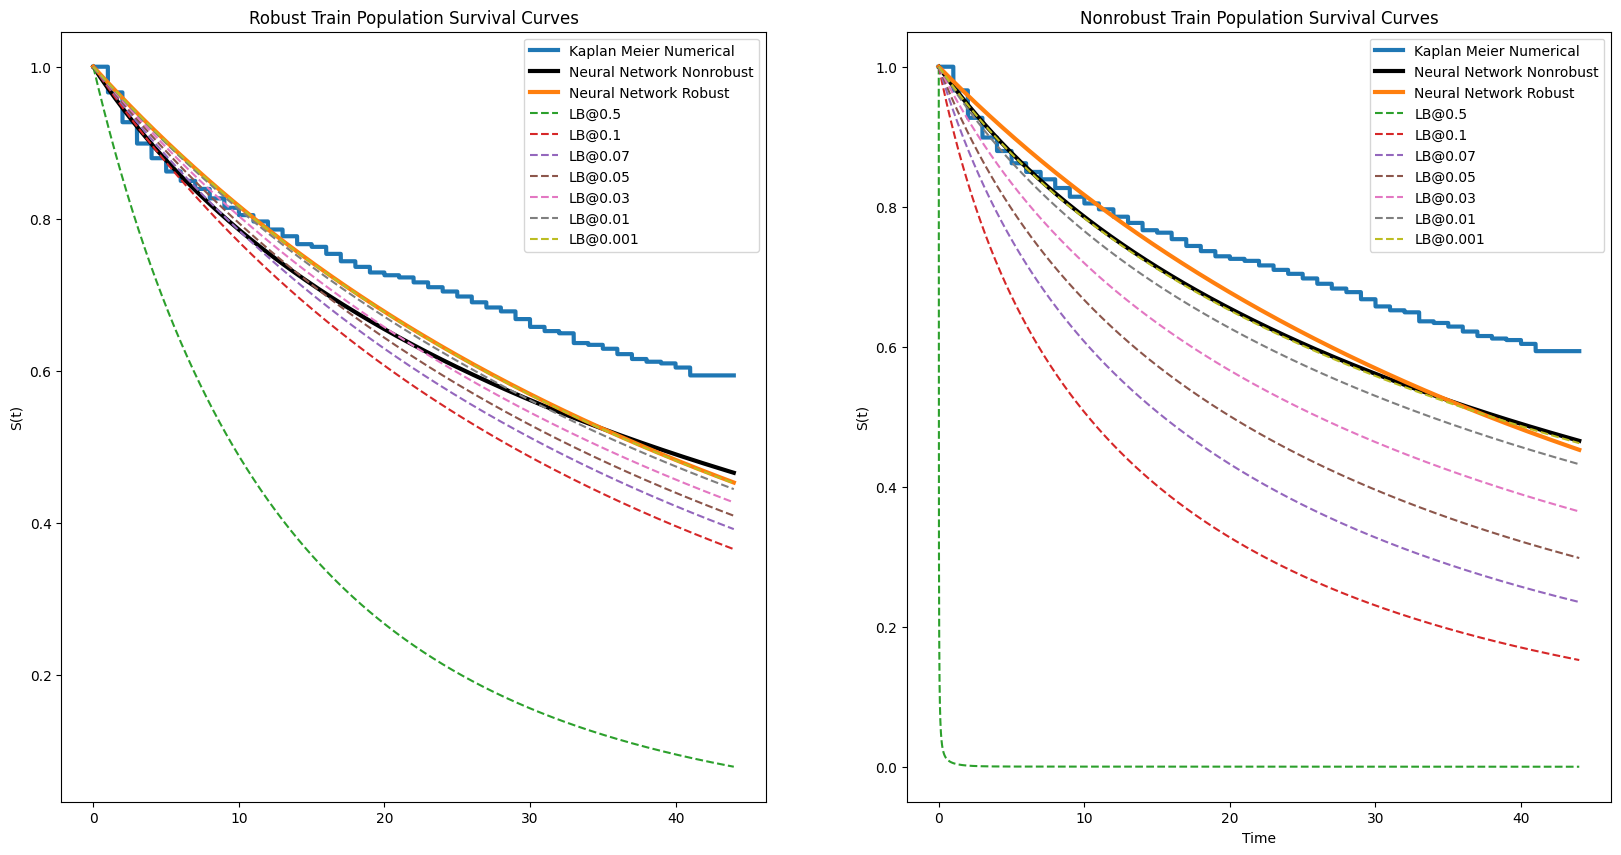

In [20]:
plt.figure(figsize=(10,10))
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_fragile_given_x = clf_fragile.survival_qdf(X_train,t).detach()
St_given_x = clf.survival_qdf(X_train,t).detach()
kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf = kmf.predict(times=t.ravel().numpy())


fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(t,St_kmf,linewidth=3)
axes[0].plot(t,St_fragile_given_x.mean(0),'k-',linewidth=3)
axes[0].plot(t,St_given_x.mean(0),linewidth=3)

epsilons = [0.5,0.1,0.07,0.05,0.03,0.01,0.001]
for epsilon in epsilons:
    lb,ub = lower_bound(clf_robust,X_train,epsilon)
    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Train CI Unperturbed",concordance_index(event_times=T_train,predicted_scores=-clf_robust.rate_logit(X_train).detach(),event_observed=E_train))
    print("Train CI Pertubed",concordance_index(event_times=T_train,predicted_scores=-ub.detach(),event_observed=E_train))
    axes[0].plot(t,St_lb.detach(),'--')



axes[0].set_ylabel("S(t)"); plt.xlabel("Time")
axes[0].legend(["Kaplan Meier Numerical","Neural Network Nonrobust","Neural Network Robust"]+[f"LB@{epsilon}" for epsilon in epsilons])
axes[0].set_title("Robust Train Population Survival Curves")

axes[1].plot(t,St_kmf,linewidth=3)
axes[1].plot(t,St_fragile_given_x.mean(0),'k-',linewidth=3)
axes[1].plot(t,St_given_x.mean(0),linewidth=3)

print("NON ROBUST")

for epsilon in epsilons:
    lb,ub = lower_bound(clf_fragile,X_train,epsilon)
    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Train CI Unperturbed",concordance_index(event_times=T_train,predicted_scores=-clf_fragile.rate_logit(X_train).detach(),event_observed=E_train))
    print("Train CI Pertubed",concordance_index(event_times=T_train,predicted_scores=-ub.detach(),event_observed=E_train))
    axes[1].plot(t,St_lb.detach(),'--')



axes[1].set_ylabel("S(t)"); plt.xlabel("Time")
axes[1].legend(["Kaplan Meier Numerical","Neural Network Nonrobust","Neural Network Robust"]+[f"LB@{epsilon}" for epsilon in epsilons])
axes[1].set_title("Nonrobust Train Population Survival Curves")

plt.show()

==========@ eps=0.5==========
Test CI Unperturbed 0.7522976453376796
Test CI Pertubed 0.7311660946426287
==========@ eps=0.1==========
Test CI Unperturbed 0.7522976453376796
Test CI Pertubed 0.7505489761974957
==========@ eps=0.07==========
Test CI Unperturbed 0.7522976453376796
Test CI Pertubed 0.7511850075929933
==========@ eps=0.05==========
Test CI Unperturbed 0.7522976453376796
Test CI Pertubed 0.7515499162823814
==========@ eps=0.03==========
Test CI Unperturbed 0.7522976453376796
Test CI Pertubed 0.7518811154190609
==========@ eps=0.01==========
Test CI Unperturbed 0.7522976453376796
Test CI Pertubed 0.7521592470420702
==========@ eps=0.001==========
Test CI Unperturbed 0.7522976453376796
Test CI Pertubed 0.7522878551045497
NON ROBUST
==========@ eps=0.5==========
Test CI Unperturbed 0.7474330119985982
Test CI Pertubed 0.6036347353021344
==========@ eps=0.1==========
Test CI Unperturbed 0.7474330119985982
Test CI Pertubed 0.7455270316124403
==========@ eps=0.07==========
Test CI

<Figure size 1000x1000 with 0 Axes>

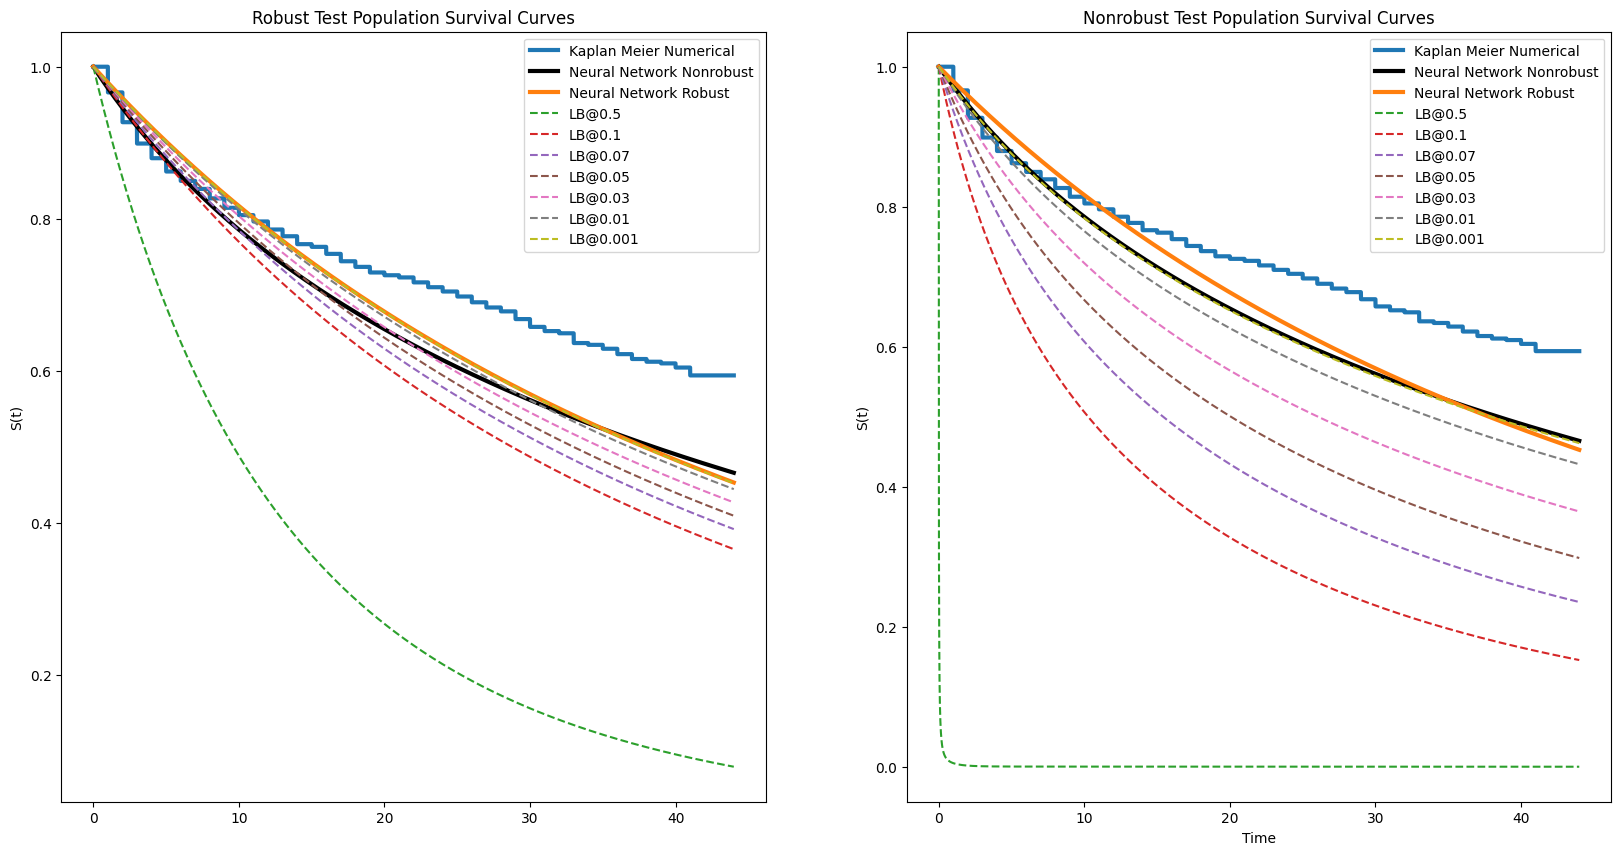

In [21]:
plt.figure(figsize=(10,10))
X_test,T_test,E_test = dataloader_train.dataset.tensors
t = torch.linspace(0,T_test.max(),10000)

St_fragile_given_x = clf_fragile.survival_qdf(X_test,t).detach()
St_given_x = clf.survival_qdf(X_test,t).detach()
kmf = KaplanMeierFitter()
kmf.fit(durations=T_test,event_observed=E_test)
St_kmf = kmf.predict(times=t.ravel().numpy())


fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(t,St_kmf,linewidth=3)
axes[0].plot(t,St_fragile_given_x.mean(0),'k-',linewidth=3)
axes[0].plot(t,St_given_x.mean(0),linewidth=3)

epsilons = [0.5,0.1,0.07,0.05,0.03,0.01,0.001]
for epsilon in epsilons:
    lb,ub = lower_bound(clf_robust,X_test,epsilon)
    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Test CI Unperturbed",concordance_index(event_times=T_test,predicted_scores=-clf_robust.rate_logit(X_test).detach(),event_observed=E_test))
    print("Test CI Pertubed",concordance_index(event_times=T_test,predicted_scores=-ub.detach(),event_observed=E_test))
    axes[0].plot(t,St_lb.detach(),'--')



axes[0].set_ylabel("S(t)"); plt.xlabel("Time")
axes[0].legend(["Kaplan Meier Numerical","Neural Network Nonrobust","Neural Network Robust"]+[f"LB@{epsilon}" for epsilon in epsilons])
axes[0].set_title("Robust Test Population Survival Curves")

axes[1].plot(t,St_kmf,linewidth=3)
axes[1].plot(t,St_fragile_given_x.mean(0),'k-',linewidth=3)
axes[1].plot(t,St_given_x.mean(0),linewidth=3)

print("NON ROBUST")

for epsilon in epsilons:
    lb,ub = lower_bound(clf_fragile,X_test,epsilon)
    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Test CI Unperturbed",concordance_index(event_times=T_test,predicted_scores=-clf_fragile.rate_logit(X_test).detach(),event_observed=E_test))
    print("Test CI Pertubed",concordance_index(event_times=T_test,predicted_scores=-ub.detach(),event_observed=E_test))
    axes[1].plot(t,St_lb.detach(),'--')



axes[1].set_ylabel("S(t)"); plt.xlabel("Time")
axes[1].legend(["Kaplan Meier Numerical","Neural Network Nonrobust","Neural Network Robust"]+[f"LB@{epsilon}" for epsilon in epsilons])
axes[1].set_title("Nonrobust Test Population Survival Curves")

plt.show()

In [22]:
lb,ub = lower_bound(clf_robust,X_test,0.1)
St_lb = torch.exp(-ub*t).detach()

tensor([2.1299, 2.2723, 2.4235, 2.4353, 2.5529, 2.5752, 2.8396, 2.8746, 2.9397,
        2.9699, 2.9889, 3.0046, 3.0592, 3.0693, 3.0869, 3.0881, 3.0886, 3.0980,
        3.1021, 3.1257, 3.1273, 3.1412, 3.1590, 3.1624, 3.1666, 3.1780, 3.1923,
        3.2097, 3.2109, 3.2145])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.86it/s]


Text(0.5, 1.0, 'Individual Survival Curves Train')

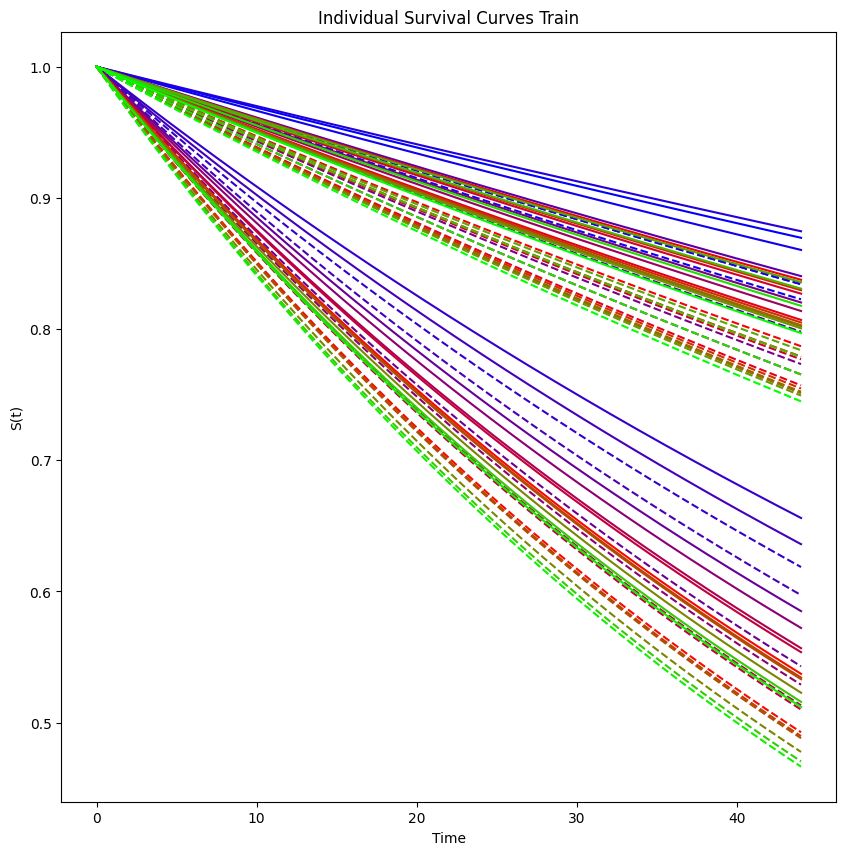

In [23]:
plt.figure(figsize=(10,10))

    
test_cases = 30

colors = list(plt.cm.brg(np.linspace(0,1,test_cases))) + ["crimson", "indigo"]

cases = np.argsort(torch.linalg.norm(St_lb - St_given_x,axis=1))[0:test_cases]
print(torch.linalg.norm(St_lb - St_given_x,axis=1)[cases])

for i,case in enumerate(tqdm(cases)):
    plt.plot(t,St_given_x[case],color=colors[i])
    plt.plot(t,St_lb[case],'--',color=colors[i])
    
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")

tensor([10.0781, 10.0541, 10.0541, 10.0538, 10.0534, 10.0519, 10.0481, 10.0461,
        10.0413,  9.9965,  9.9923,  9.9776,  9.9746,  9.9302,  9.9116,  9.8475,
         9.8267,  9.8037,  9.7931,  9.7856,  9.7494,  9.7354,  9.7279,  9.6994,
         9.6967,  9.6916,  9.6904,  9.6625,  9.6551,  9.6383])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.83it/s]


Text(0.5, 1.0, 'Individual Survival Curves Train')

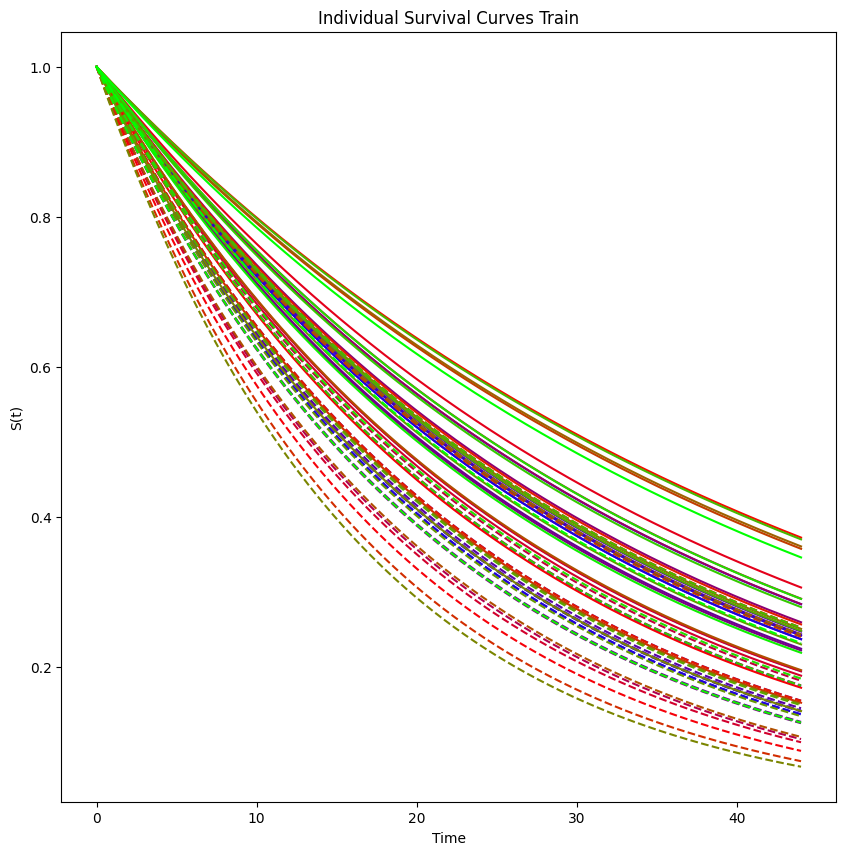

In [24]:
plt.figure(figsize=(10,10))
# lb,ub = lower_bound(model,X_train,0.1)
    
test_cases = 30
cases = torch.flip(np.argsort(torch.linalg.norm(St_lb - St_given_x,axis=1)),dims=(0,))[0:test_cases]
print(torch.linalg.norm(St_lb - St_given_x,axis=1)[cases])
for i,case in enumerate(tqdm(cases)):
    plt.plot(t,St_given_x[case],color=colors[i])
    plt.plot(t,St_lb[case],'--',color=colors[i])
    
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")
